# Housing prices in Hyderabad, India

## Project Objective 🎯

The objective of this project is to develop a regression model to predict housing prices in Hyderabad, India. Using features such as the property's area, location, number of bedrooms, and available amenities, the model will aim to estimate the market value of a property as accurately as possible.

- This predictive model will be a valuable tool for:
- Home Buyers and Sellers: To obtain an objective price estimate for a property.
- Real Estate Agents: To assist with property valuation and client advisory.
- Investors: To identify potentially undervalued or overvalued properties in the market.

## 4. Training the models

### 4.1 Loading the dataset

In [20]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import Lasso 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from IPython.display import display
import sys

sys.path.append('../../src/utils')


# Utilities
from housing_prices_column_definition import Column


training_features = pd.read_parquet('../../datasets/processed/housing_prices/hyderabad_house_price_training_features.parquet')
training_labels = pd.read_parquet('../../datasets/processed/housing_prices/hyderabad_house_price_training_labels.parquet')

test_features = pd.read_parquet('../../datasets/processed/housing_prices/hyderabad_house_price_test_features.parquet')
test_labels= pd.read_parquet('../../datasets/processed/housing_prices/hyderabad_house_price_test_labels.parquet')

target_metrics = '../../datasets/processed/housing_prices/hyderabad_house_price_metrics.csv'

## 4.2 Understanding the linear regression model

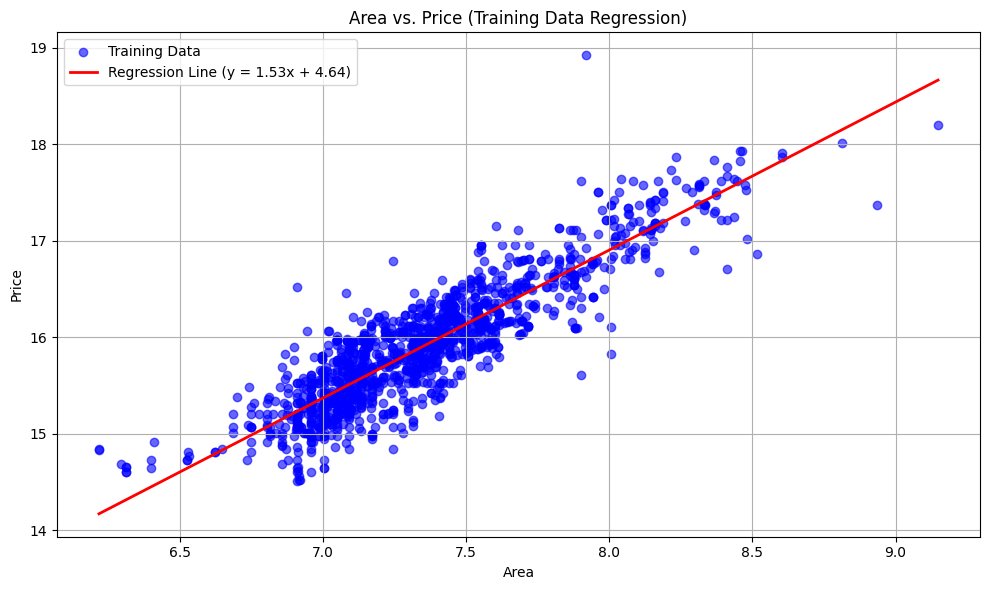

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression


training_features_simple = training_features[[Column.AREA.name]]
linealRegresion_simple = LinearRegression()
linealRegresion_simple.fit(training_features_simple, training_labels)


weight_simple = linealRegresion_simple.coef_[0][0]
intercept_simple = linealRegresion_simple.intercept_[0]

x = training_features[Column.AREA.name]
y = training_labels


plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.6, color='blue', label='Training Data')


x_line = np.linspace(x.min(), x.max(), 100)
y_line = weight_simple * x_line + intercept_simple


plt.plot(x_line, y_line, color='red', linewidth=2, label=f'Regression Line (y = {weight_simple:.2f}x + {intercept_simple:.2f})')


plt.title('Area vs. Price (Training Data Regression)')
plt.xlabel(Column.AREA.name)
plt.ylabel(Column.PRICE.name)
plt.legend()
plt.grid(True)
plt.tight_layout()


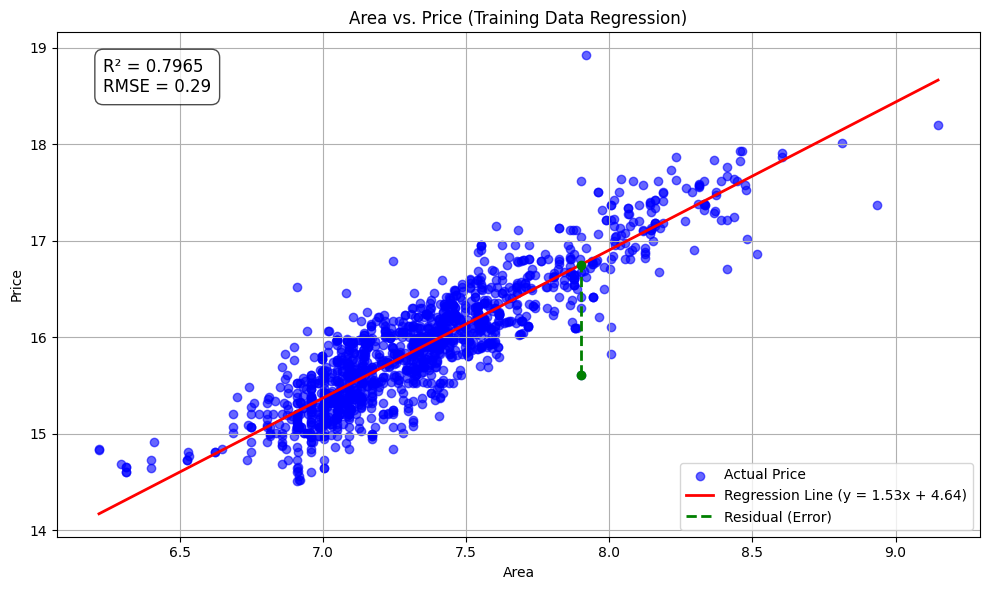

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score # Importar métricas


training_features_simple = training_features[[Column.AREA.name]]
linealRegresion_simple = LinearRegression()
linealRegresion_simple.fit(training_features_simple, training_labels)


weight_simple = linealRegresion_simple.coef_[0][0]
intercept_simple = linealRegresion_simple.intercept_[0]

x = training_features[Column.AREA.name]
y = training_labels[Column.PRICE.name] 


# 1. Calcular predicciones y métricas (R² y RMSE)
y_pred = linealRegresion_simple.predict(training_features_simple)
y_pred_1d = y_pred.ravel() # Convertir de (n, 1) a (n,)

r2 = r2_score(y, y_pred_1d)
rmse = np.sqrt(mean_squared_error(y, y_pred_1d))

# 2. Encontrar el punto distante *debajo* de la línea
# Calculamos los residuos (error = real - predicción)
residuals = y - y_pred_1d

# Encontramos el índice del residuo más pequeño (el más negativo)
idx_distant_point = np.argmin(residuals)

# Obtenemos las coordenadas de ese punto específico
# Usamos .iloc[] porque 'x' e 'y' son probablemente Series de Pandas
x_point = x.iloc[idx_distant_point]
y_real_point = y.iloc[idx_distant_point]

# Calculamos el valor predicho *en la línea* para ese x
y_pred_point = weight_simple * x_point + intercept_simple


plt.figure(figsize=(10, 6))
ax = plt.gca() 

plt.scatter(x, y, alpha=0.6, color='blue', label='Actual Price')

x_line = np.linspace(x.min(), x.max(), 100)
y_line = weight_simple * x_line + intercept_simple

plt.plot(x_line, y_line, color='red', linewidth=2, label=f'Regression Line (y = {weight_simple:.2f}x + {intercept_simple:.2f})')

# 3. Agregar la línea vertical punteada (residuo)
plt.plot(
    [x_point, x_point],             # Coordenadas X (inicio y fin)
    [y_real_point, y_pred_point],   # Coordenadas Y (inicio y fin)
    color='green',
    linestyle='--',
    linewidth=2,
    label='Residual (Error)'
)
# Opcional: marcar los puntos de inicio y fin de la línea de residuo
plt.plot(x_point, y_real_point, 'go') # Punto real
plt.plot(x_point, y_pred_point, 'go') # Punto predicho en la línea


# 4. Agregar las fórmulas (valores) de R² y RMSE
text_str = f'R² = {r2:.4f}\nRMSE = {rmse:.2f}'

# Usamos transform=ax.transAxes para posicionar el texto en coordenadas relativas
# (0,0) es abajo izquierda, (1,1) es arriba derecha
ax.text(
    0.05, 0.95, # Posición (5% desde la izquierda, 95% desde abajo)
    text_str,
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='top', # Alineación vertical
    # Añadir un recuadro blanco para mejor legibilidad
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7)
)


plt.title('Area vs. Price (Training Data Regression)')
plt.xlabel(Column.AREA.name)
plt.ylabel(Column.PRICE.name)
# Asegurarnos de que la leyenda incluya la nueva línea 'Residual'
plt.legend() 
plt.grid(True)
plt.tight_layout()
plt.show()

### 4.3 Model Validation

**Problem:**

How to systematically find the best regression model and its optimal hyperparameters for our dataset.

**Justification:**

Since no single model is universally best (the "No Free Lunch" theorem), a systematic comparison is essential. GridSearchCV is the standard tool for this, as it exhaustively explores hyperparameter combinations and uses cross-validation to provide a robust estimate of model performance on unseen data.

**Action:**

The code iterates through a predefined list of models (e.g., Linear Regression, Lasso, Ridge) and their respective hyperparameter grids. For each model, it performs an exhaustive GridSearchCV with 10-fold cross-validation to find the best parameter set based on R² and RMSE metrics. All results are then compiled into a single Pandas DataFrame and saved to a CSV file for analysis.

**Verify:**

Success is verified by inspecting the final final_metrics DataFrame. It should contain the consolidated performance metrics for all evaluated models. The creation of the target CSV file also confirms that the process completed successfully.

In [15]:
folds = 10
max_components = training_features.shape[1]

scoring_metrics = {
    'neg_rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

models_configuration = [
    {
        'name': 'DLR',
        'pipeline': Pipeline([
            ('regresion', LinearRegression())
        ]),
        'param_grid': {
            'regresion__fit_intercept': [True, False]  # mx + b , mx
        }
    },
    {
        'name': 'PCA+DLR',
        'pipeline': Pipeline([
            ('pca', PCA()),
            ('regresion', LinearRegression())
        ]),
        'param_grid': {
            'pca__n_components': range(1, max_components + 1),
            'pca__whiten': [True, False],  # transform each new component to hava variance 0
        }
    },
    {
        'name': 'L1',
        'pipeline': Pipeline([
            ('regresion', Lasso(max_iter=10000)) # Aumentar max_iter es buena práctica
        ]),
        'param_grid': {
            'regresion__alpha': np.logspace(-4, 1, 30)
        }
    },
    {
        'name': 'L2',
        'pipeline': Pipeline([
            ('regresion', Ridge())
        ]),
        'param_grid': {
            'regresion__alpha': np.logspace(-4, 4, 30)
        }
    },
    {
        'name': 'L1+L2',
        'pipeline': Pipeline([
            ('regresion', ElasticNet(max_iter=10000))
        ]),
        'param_grid': {
            'regresion__alpha': np.logspace(-4, 1, 30), # Fuerza total
            'regresion__l1_ratio': np.arange(0.1, 1.0, 0.1) # Mezcla L1/L2
        }
    },
    {
        'name': 'PCA+L1',
        'pipeline': Pipeline([
            ('pca', PCA()),
            ('regresion', Lasso(max_iter=10000))
        ]),
        'param_grid': {
            'pca__n_components': range(1, max_components + 1),
            'regresion__alpha': np.logspace(-4, 1, 30)
        }
    }
]

all_metrics = []

for config in models_configuration:
    model_name = config['name']
    pipeline = config['pipeline']
    param_grid = config['param_grid']
    
    print(f"--- Executing: {model_name} ---")

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring_metrics,
        refit='r2',
        cv=folds,
        n_jobs=-1
    )

    grid_search.fit(training_features, training_labels)

    grid_metrics = pd.DataFrame(grid_search.cv_results_)
    grid_metrics['model_name'] = model_name
    
    all_metrics.append(grid_metrics)

final_metrics = pd.concat(all_metrics, ignore_index=True)
final_metrics['params'] = final_metrics['params'].astype(str)

final_metrics.to_csv(target_metrics)

display(final_metrics)

--- Executing: DLR ---
--- Executing: PCA+DLR ---
--- Executing: L1 ---
--- Executing: L2 ---
--- Executing: L1+L2 ---
--- Executing: PCA+L1 ---


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regresion__fit_intercept,params,split0_test_neg_rmse,split1_test_neg_rmse,split2_test_neg_rmse,split3_test_neg_rmse,...,split8_test_r2,split9_test_r2,mean_test_r2,std_test_r2,rank_test_r2,model_name,param_pca__n_components,param_pca__whiten,param_regresion__alpha,param_regresion__l1_ratio
0,0.008874,0.002107,0.003200,0.000813,True,{'regresion__fit_intercept': True},-0.258010,-0.235140,-0.200422,-0.236432,...,0.869049,0.871474,0.865984,0.045106,1,DLR,NaN,NaN,NaN,NaN
1,0.009736,0.001447,0.004000,0.000298,False,{'regresion__fit_intercept': False},-0.326480,-0.278803,-0.274026,-0.255292,...,0.801262,0.782330,0.801072,0.048315,2,DLR,NaN,NaN,NaN,NaN
2,0.006771,0.000740,0.003476,0.000751,NaN,"{'pca__n_components': 1, 'pca__whiten': True}",-0.589999,-0.583586,-0.573684,-0.605158,...,0.152395,0.211369,0.208900,0.077873,173,PCA+DLR,1.0,True,NaN,NaN
3,0.006463,0.001260,0.003298,0.001022,NaN,"{'pca__n_components': 1, 'pca__whiten': False}",-0.589999,-0.583586,-0.573684,-0.605158,...,0.152395,0.211369,0.208900,0.077873,173,PCA+DLR,1.0,False,NaN,NaN
4,0.006547,0.001607,0.002984,0.000776,NaN,"{'pca__n_components': 2, 'pca__whiten': True}",-0.425748,-0.407447,-0.403174,-0.418704,...,0.584162,0.643420,0.612292,0.052087,171,PCA+DLR,2.0,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3111,0.014849,0.000459,0.007066,0.002440,NaN,"{'pca__n_components': 87, 'regresion__alpha': ...",-0.685871,-0.659323,-0.628748,-0.685061,...,-0.016161,-0.000687,-0.006274,0.007100,1915,PCA+L1,87.0,NaN,2.043360,NaN
3112,0.014658,0.000769,0.006379,0.000517,NaN,"{'pca__n_components': 87, 'regresion__alpha': ...",-0.685871,-0.659323,-0.628748,-0.685061,...,-0.016161,-0.000687,-0.006274,0.007100,1915,PCA+L1,87.0,NaN,3.039195,NaN
3113,0.015456,0.002159,0.006543,0.000616,NaN,"{'pca__n_components': 87, 'regresion__alpha': ...",-0.685871,-0.659323,-0.628748,-0.685061,...,-0.016161,-0.000687,-0.006274,0.007100,1915,PCA+L1,87.0,NaN,4.520354,NaN
3114,0.014803,0.000744,0.006118,0.000838,NaN,"{'pca__n_components': 87, 'regresion__alpha': ...",-0.685871,-0.659323,-0.628748,-0.685061,...,-0.016161,-0.000687,-0.006274,0.007100,1915,PCA+L1,87.0,NaN,6.723358,NaN
